### Forecast experiment 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
import keras
import seaborn as sns

# in time series forecasting, we usually need to scale our values
# for better end results
from sklearn.preprocessing import MinMaxScaler

2025-11-17 14:23:56.629079: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-17 14:23:56.673832: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-17 14:23:57.819340: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# let's try a pandas DataFrame instead
df = pd.read_csv("../datasets/Task_4/3.csv")


In [3]:
df

,School DBN,Date,Enrolled,Absent,Present,Released
0,01M015,20180905,172,19,153,0
1,01M015,20180906,171,17,154,0
2,01M015,20180907,172,14,158,0
3,01M015,20180912,173,7,166,0
4,01M015,20180913,173,9,164,0
...,...,...,...,...,...,...
10608,02M217,20181109,617,47,570,0
10609,02M217,20181113,617,18,599,0
10610,02M217,20181114,617,21,596,0
10611,02M217,20181115,617,55,562,0


**Before going any further, scale the values in our DataFrame**

In [4]:
# scale the values with MinMaxScaler so that we don't
# affect the distribution of data (thus making the signal not realistic anymore)
# MinMaxScaler is a good solution here
scaler = MinMaxScaler()
df[['Absent']] = scaler.fit_transform(df[['Absent']])

scaler = MinMaxScaler()
df[['Present']] = scaler.fit_transform(df[['Present']])

scaler = MinMaxScaler()
df[['Released']] = scaler.fit_transform(df[['Released']])

# as weird as it sounds, scaling the index/sequence number also
# to be a decimal might affect the performance of the network
df.index = df.index * 0.1 + 1

In [5]:
df

,School DBN,Date,Enrolled,Absent,Present,Released
1.0,01M015,20180905,172,0.040860,0.088014,0.0
1.1,01M015,20180906,171,0.036559,0.088593,0.0
1.2,01M015,20180907,172,0.030108,0.090909,0.0
1.3,01M015,20180912,173,0.015054,0.095541,0.0
1.4,01M015,20180913,173,0.019355,0.094383,0.0
...,...,...,...,...,...,...
1061.8,02M217,20181109,617,0.101075,0.329473,0.0
1061.9,02M217,20181113,617,0.038710,0.346265,0.0
1062.0,02M217,20181114,617,0.045161,0.344528,0.0
1062.1,02M217,20181115,617,0.118280,0.324841,0.0


In [6]:
# let's figure out a good cutoff point for train/test
# 67% for training, 33% testing (NOTE: you should experiment on this to find optimal %)
cutoff = int(len(df) * 0.67)

# train data
X_train = df.index[0:cutoff]
y_train = df[['Absent','Present','Released']].iloc[0:cutoff]

# test data
X_test = df.index[cutoff:]
y_test = df[['Absent','Present','Released']].iloc[cutoff:]

# convert everything into NumPy -array format
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# in this case, number of variables is 1 => scaled passengers value
n_features = 3

# use reshape tools to get the data ready for future use
train_series = y_train.reshape((len(y_train), n_features))
test_series  = y_test.reshape((len(y_test), n_features))


In [7]:
train_series

array([[0.04086022, 0.0880139 , 0.        ],
       [0.03655914, 0.08859294, 0.        ],
       [0.03010753, 0.09090909, 0.        ],
       ...,
       [0.01075269, 0.20440069, 0.        ],
       [0.02150538, 0.2015055 , 0.        ],
       [0.0172043 , 0.20266358, 0.        ]], shape=(7110, 3))

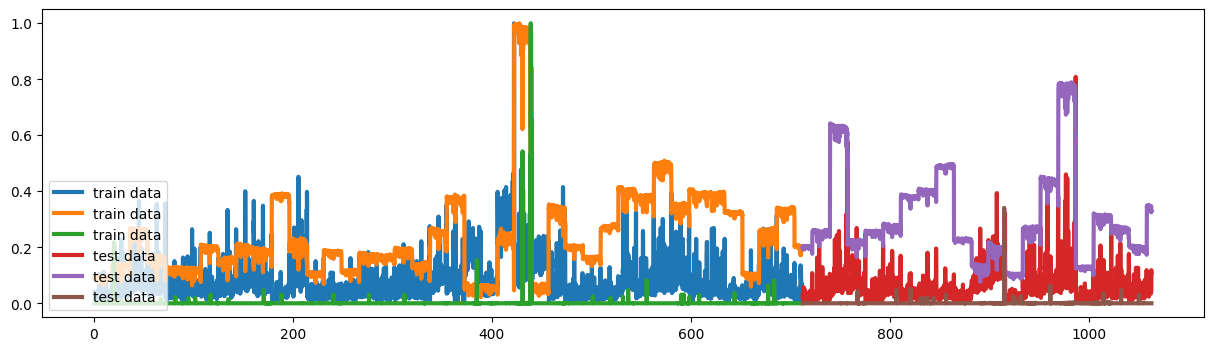

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(X_train,y_train, lw=3, label='train data')
ax.plot(X_test, y_test,  lw=3, label='test data')
ax.legend(loc="lower left")
plt.show()

In [9]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# the variable that determines how many points
# back into the past the model attempts to learn
look_back  = 12
batch_size = 1

# stride = 1 => means we use separate time steps
# more than 1 => we use windowing

# TimeseriesGenerators were deprecated by TensorFlow developers
# during October 2024
# this means, in some unknown future TensorFlow -version
# this feature will removed
# check the other version of this notebook on how to replace
# TimeseriesGenerator with a TensorFlow Dataset
train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = batch_size)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = batch_size)

In [10]:
from keras.models import Sequential
from keras import Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

# create a model checkpoint to a file, and only save the best one
mc = ModelCheckpoint('best_model_flights.keras', monitor='val_loss', mode='min', save_best_only=True)
callback_list = [mc]

# build the neural network
# in this case, LSTM with 8 neurons
n_neurons  = 64

model = Sequential()
model.add(Input(shape=(look_back, n_features)))
model.add(SimpleRNN(n_neurons, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

initial_weights = model.get_weights()

# it's not optimal to use test data as validation data
# because this might skew our metrics
# see the other version of this notebook on how to do
# train/validation/test -split for the sine wave
model.fit(train_generator, epochs=200, verbose=1, validation_data=test_generator, callbacks=callback_list)


Epoch 1/200


2025-11-17 14:23:58.196529: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/lukas/dev/venvs/DL/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7098/7098 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0165 - val_loss: 0.0243
Epoch 2/200
7098/7098 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0165 - val_loss: 0.0243
Epoch 3/200
7098/7098 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0165 - val_loss: 0.0243
Epoch 4/200
7098/7098 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0165 - val_loss: 0.0243
Epoch 5/200
7098/7098 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0164 - val_loss: 0.0243
Epoch 6/200
7098/7098 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0164 - val_loss: 0.0243
Epoch 7/200
7098/7098 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0164 - val_loss: 0.0243
Epoch 8/200
7098/7098 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0164 - val_loss: 0.0243
Epoch 9/200
7098/7098 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0164 - val_loss: 0.0243
Epoch 10/200
7098/7098 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0164 - val_loss: 0.0243
Epoch 11/200
7098/7098 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0164 - val_loss: 0.0243
Epoch 12/200
7098/70

## Problem:
I had to cancel the first run because the dataset is way too big.
The csv has 9mb and ~300k rows so training the network took 7 minutes for 1 out of 300 epochs.

Even only with 70k rows it still takes ~1min / epoch so I have to further reduce the amount of data. Unfortunately I dont have the time to spend more than 3 hours on training the network.

Now I reduced the row count to ~10k, this reduces computing time down to ~15seconds per step so ~50minutes

**Training metrics**

<Axes: >

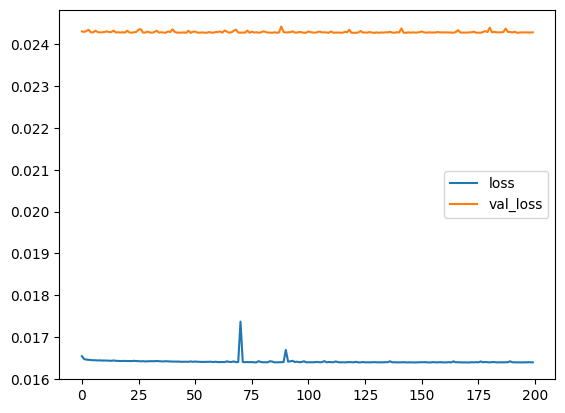

In [11]:
# the usual training metrics visualization
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [19]:
# reload the best version of the model
from keras.models import load_model
model = load_model("best_model_flights.keras")
#todo: rename best model file

In [20]:
# TensorFlow evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

# these values are very close to each other, 
# which means our model is quite optimal
# IN THEORY 

7098/7098 ━━━━━━━━━━━━━━━━━━━━ 6s 825us/step - loss: 0.0164
Training loss: 0.016384311020374298
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 3s 849us/step - loss: 0.0243
Testing loss: 0.02427515760064125


**Test predictions**

In [14]:
test_predictions  = model.predict(test_generator)

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 3s 826us/step


**Conventional regression metrics + MAPE**

In [26]:
# let's make a separate copy of the test values
# so we can calculate some errors
# Example: if test_predictions is for 'Absent'


# see markdown box below for explanation why this is happening
mape = mean_absolute_percentage_error(
    actual_y_test[:, 0],  # Only the 'Absent' column
    test_predictions
) * 100

actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
#mape = mean_absolute_percentage_error(actual_y_test, test_predictions) * 100

# print out the MAPE-score
print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

# MAE - Mean average error
#print("\nMAE")
#print(round(metrics.mean_absolute_error(actual_y_test, test_predictions), 2), "units")

# MSE - Mean square error
#print("\nMSE")
#print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), "units^2")

# RMSE - Root mean square error
#print('\nRMSE:')
#print(round(np.sqrt(metrics.mean_squared_error(actual_y_test, test_predictions)), 2), "units")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
#print('\nR-squared:')
#print(round(metrics.r2_score(actual_y_test, test_predictions), 2))



#Something seems to be very wrong with my approach

MAPE (mean average precision error):
42907556909697.05 %


---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Cell In[15], line 6
      4 actual_y_test = np.concatenate([y for x, y in test_generator])
      5 errors = np.abs(actual_y_test - test_predictions)
----> 6 mape = mean_absolute_percentage_error(actual_y_test, test_predictions) * 100
      8 # print out the MAPE-score
      9 print("MAPE (mean average precision error):")

File ~/dev/venvs/DL/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:218, in validate_params.<locals>.decorator.<locals>.wrapper(*args, **kwargs)
    212 try:
    213     with config_context(
    214         skip_parameter_validation=(
    215             prefer_skip_nested_validation or global_skip_validation
    216         )
    217     ):
--> 218         return func(*args, **kwargs)
    219 except InvalidParameterError as e:
    220     # When the function is just a wrapper around an estimator, we allow
    221     # the function to delegate validation to the estimator, but we replace
    222     # the name of the estimator by the name of the function in the error
    223     # message to avoid confusion.
    224     msg = re.sub(
    225         r"parameter of \w+ must be",
    226         f"parameter of {func.__qualname__} must be",
...
    131     )
    133 n_outputs = y_true.shape[1]
    134 allowed_multioutput_str = ("raw_values", "uniform_average", "variance_weighted")

ValueError: y_true and y_pred have different number of output (3!=1)
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...






Fix for error:
Since the model only predicts one column we have to check against only one column aswell
=> ask ai how to do that with the code as context and the error as context
result:

Example: if test_predictions is for 'Absent'
mape = mean_absolute_percentage_error(
    actual_y_test[:, 0],  # Only the 'Absent' column
    test_predictions
) * 100


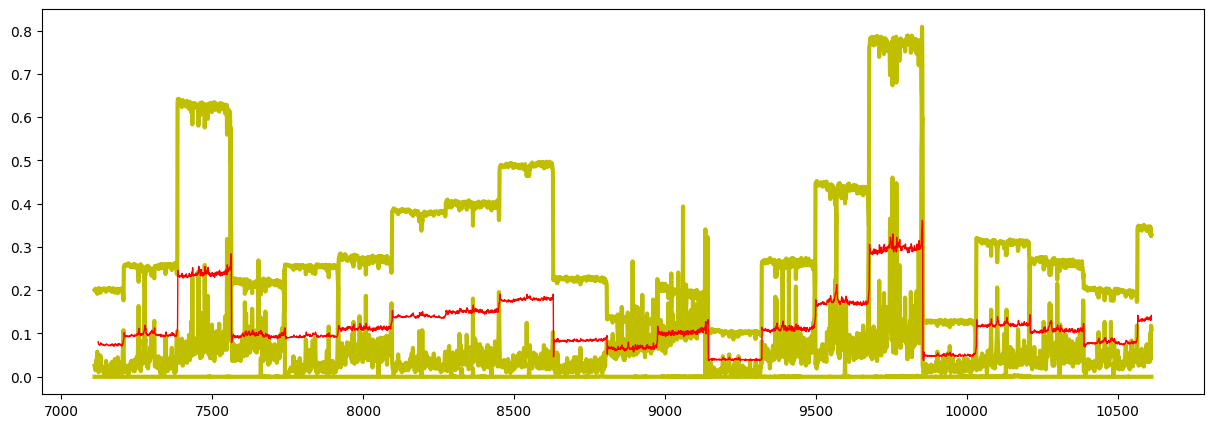

In [21]:
# calculate helper x-variables for where the train data starts
# where the test data starts and where the predictions start
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(y_test))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, test_predictions, lw=1, c='r', label='predictions')
# ax.legend(loc="lower left")
plt.show()

In [27]:
# TensorFlow evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

# some difference here which we can see in the test-signal prediction already 

7098/7098 ━━━━━━━━━━━━━━━━━━━━ 6s 802us/step - loss: 0.0164
Training loss: 0.016384311020374298
2001/3491 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - loss: 0.0244

KeyboardInterrupt: 

**Extrapolation into the future**

In [ ]:
# EXTRAPOLATION TEST 1 - 180 new points
extrapolation = list()
seed_batch    = y_test[:look_back].reshape((1,look_back, n_features))
current_batch = seed_batch

# extrapolate the next 180 values
for i in range(120):
    predicted_value = model.predict(current_batch, verbose=None)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 3 and the array at index 1 has size 1

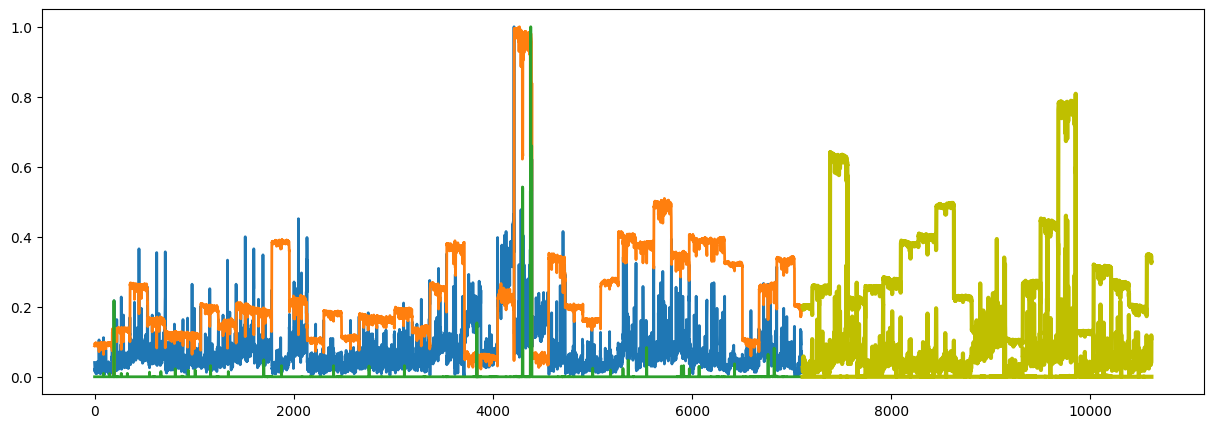

In [28]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(extrapolation) + look_back)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, extrapolation, lw=1, c='r', label='predictions')
# ax.legend(loc="lower left")
plt.show()